# Evaluating causal models with observation train, random test

- Ordered Sensitivity
- Cumulative sensitivity curve 
- Cumulative Gain Curve 

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
plt.style.use('dark_background')
import seaborn as sns
import pandas as pd 
from scipy import stats
import graphviz as gr
from linearmodels.iv import IV2SLS
import statsmodels.api as sm
import statsmodels.formula.api as smf
from data_loader import load

In [8]:
prices = load("ice_cream_sales.csv") # loads non-random data
prices_rnd = load("ice_cream_sales_rnd.csv") # loads random data
print(prices_rnd.shape, prices.shape)
prices.head()

(5000, 5) (10000, 5)


,temp,weekday,cost,price,sales
0,17.3,6,1.5,5.6,173
1,25.4,3,0.3,4.9,196
2,23.3,5,1.5,7.6,207
3,26.9,1,0.3,5.3,241
4,20.2,1,1.0,7.2,227


Fit on observational data, evaluate on random data 

In [4]:
m1 = smf.ols("sales ~ price*cost + price*C(weekday) + price*temp", data=prices).fit()

In [6]:
from sklearn.ensemble import GradientBoostingRegressor

X = ["temp", "weekday", "cost", "price"]
y = "sales"

m2 = GradientBoostingRegressor(random_state=0)
m2.fit(prices[X], prices[y])

GradientBoostingRegressor(random_state=0)

In [7]:
print("Train Score:", m2.score(prices[X], prices[y]))
print("Test Score:", m2.score(prices_rnd[X], prices_rnd[y]))

Train Score: 0.9251704824568053
Test Score: 0.7710846755988507


In [9]:
def predict_sensitivity(model, price_df, h=0.01):
    """numerical approx to sensitivy. dy/dt"""
    return (model.predict(price_df.assign(price=price_df["price"]+h))
            - model.predict(price_df)) / h


np.random.seed(123)
prices_rnd_pred = prices_rnd.assign(**{
    "sensitivity_m_pred": predict_sensitivity(m1, prices_rnd), ## sensitivity model
    "pred_m_pred": m2.predict(prices_rnd[X]), ## predictive model
    "rand_m_pred": np.random.uniform(size=prices_rnd.shape[0]), ## random model
})

prices_rnd_pred.head()

,temp,weekday,cost,price,sales,sensitivity_m_pred,pred_m_pred,rand_m_pred
0,25.8,1,0.3,7,230,-13.096964,224.067406,0.696469
1,22.7,3,0.5,4,190,1.054695,189.889147,0.286139
2,33.7,7,1.0,5,237,-17.362642,237.255157,0.226851
3,23.0,4,0.5,5,193,0.564985,186.688619,0.551315
4,24.4,1,1.0,3,252,-13.717946,250.342203,0.719469


In [12]:
def sensitivity(data, y, t):
        # line coeficient for the one variable linear regression 
        
        return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /
                np.sum((data[t] - data[t].mean())**2))

In [32]:
def sensitivity_by_band(df, pred, y, t, bands=10):
    def apply_sensitivity(group):
        return sensitivity(data=group, y=y, t=t)
        
    return (df
            .assign(**{f"{pred}_band":pd.qcut(df[pred], q=bands)}) # makes quantile partitions
            .groupby(f"{pred}_band", observed=True)
            .apply(apply_sensitivity, include_groups=False)
    )

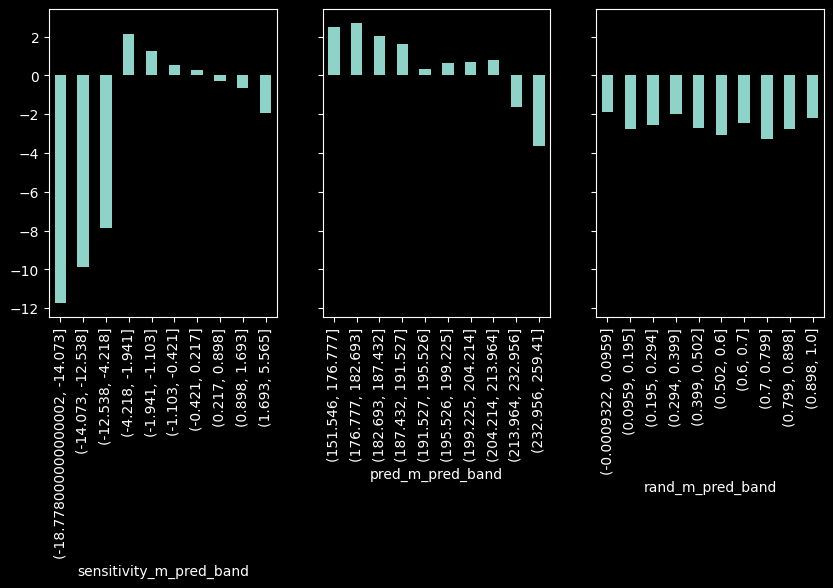

In [33]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(10, 4))
for m, ax in zip(["sensitivity_m_pred", "pred_m_pred", "rand_m_pred"], axs):
    sensitivity_by_band(prices_rnd_pred, m, "sales", "price").plot.bar(ax=ax)

So the predictions are just used to bin the data. then sensitivie is calculated on that bin. 

pred_m isn't a causal model. its just a predictor of y|x with ml model. 
sensitivity_m is a causal model using ols + sensitivity as numerical gradient e.g. h=0.001 

# Cumulative sensitivity curve

5000


,temp,weekday,cost,price,sales,sensitivity_m_pred,pred_m_pred,rand_m_pred
0,10.0,4,0.5,10,139,5.565385,151.546772,0.097863
1,12.1,3,0.3,3,172,5.463226,167.886506,0.404197
2,10.9,2,0.5,6,149,5.246731,156.060580,0.052091
3,11.8,4,0.3,9,156,5.204304,158.934195,0.310509
4,12.6,5,0.3,5,161,5.141863,161.177555,0.194223
...,...,...,...,...,...,...,...,...
4995,32.8,1,1.5,3,247,-17.777179,250.792362,0.073776
4996,33.4,7,1.5,3,259,-18.075453,247.258424,0.776510
4997,38.2,1,0.5,7,226,-18.197858,229.772560,0.594480
4998,34.1,7,1.5,7,208,-18.344705,217.638442,0.553257


5000


,temp,weekday,cost,price,sales,sensitivity_m_pred,pred_m_pred,rand_m_pred
0,35.6,1,0.5,3,251,-17.197778,259.410491,0.427721
1,33.8,1,0.5,3,253,-16.505415,256.762577,0.739132
2,34.8,1,0.5,4,255,-16.890061,256.013154,0.369830
3,33.0,1,0.3,3,264,-15.866416,255.935027,0.686929
4,17.4,7,0.3,3,235,-9.933424,254.491365,0.961458
...,...,...,...,...,...,...,...,...
4995,15.0,5,0.3,10,162,4.218712,157.923496,0.056074
4996,15.0,3,0.3,10,162,4.347752,157.923496,0.852004
4997,14.7,4,0.5,10,162,3.757548,156.855266,0.869476
4998,10.9,2,0.5,6,149,5.246731,156.060580,0.052091


5000


,temp,weekday,cost,price,sales,sensitivity_m_pred,pred_m_pred,rand_m_pred
0,27.6,1,1.0,5,238,-14.948814,236.616372,0.999890
1,27.0,7,0.5,3,256,-13.957308,250.265596,0.999644
2,27.4,7,0.5,10,179,-14.111167,182.201945,0.999474
3,21.2,6,1.5,4,193,-0.115289,191.358870,0.999363
4,20.6,1,1.0,5,240,-12.256291,236.464024,0.999201
...,...,...,...,...,...,...,...,...
4995,28.8,2,1.0,4,217,-2.466639,207.325456,0.000557
4996,21.7,2,1.5,10,200,-0.563857,181.716802,0.000136
4997,22.8,6,1.5,3,206,-0.730723,198.799916,0.000120
4998,29.0,3,1.0,10,232,-2.196780,184.372670,0.000082


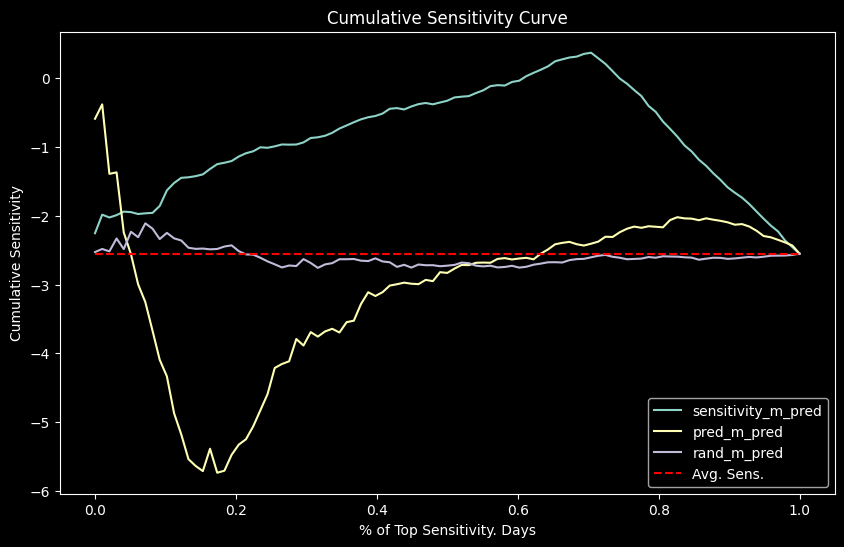

In [48]:
def cumulative_sensitivity_curve(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    print(size)
    # orders the dataset by the `prediction` column
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    display(ordered_df)
    # create a sequence of row numbers that will define our Ks
    # The last item is the sequence is all the rows (the size of the dataset)
    n_rows = list(range(min_periods, size, size // steps)) + [size]

    # cumulative computes the sensitivity. First for the top min_periods units.
    # then for the top (min_periods + step*1), then (min_periods + step*2) and so on
    groups = [ordered_df.head(rows) for rows in n_rows]
    return np.array([sensitivity(group, y, t) for group in groups])
    

plt.figure(figsize=(10,6))

for m in ["sensitivity_m_pred", "pred_m_pred", "rand_m_pred"]:
    cumu_sens = cumulative_sensitivity_curve(prices_rnd_pred, m, "sales", "price", min_periods=100, steps=100)
    x = np.array(range(len(cumu_sens)))
    plt.plot(x/x.max(), cumu_sens, label=m)

plt.hlines(sensitivity(prices_rnd_pred, "sales", "price"), 0, 1, linestyles="--", color="red", label="Avg. Sens.")
plt.xlabel("% of Top Sensitivity. Days")
plt.ylabel("Cumulative Sensitivity")
plt.title("Cumulative Sensitivity Curve")
plt.legend();

Ordering by prediction (most sensitive first?), cumulative dataframes, sensitivity on dataframes 
Interpretation:
- X axis is percentage of samples treating
- Y axis is expected sensitivity with that many samples
- An ideal curve then would start high up on the Y axis and descend very slowly to the average sensitivity,

Average sensitivity is just sensitivity on all the data 

# Cumulative gain curve 
multiply the cumulative sensitivity by the proportional sample size

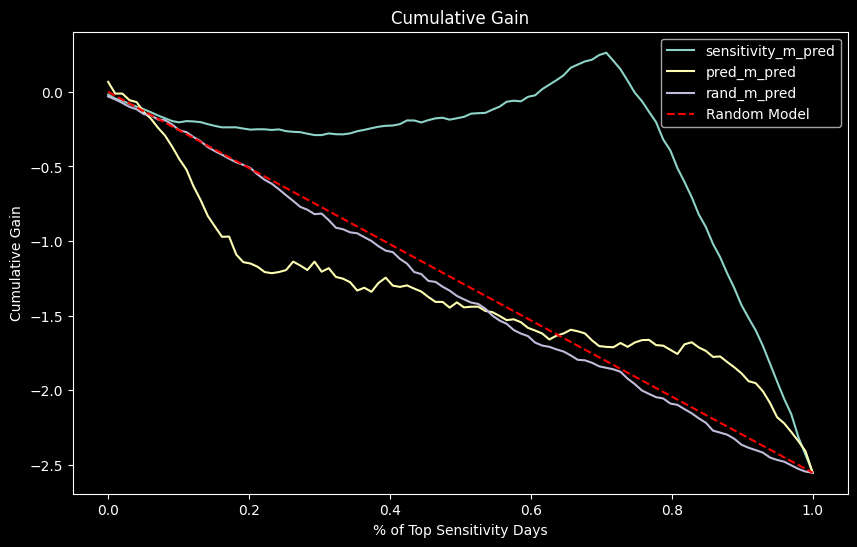

In [50]:
def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    
    ## add (rows/size) as a normalizer. 
    return np.array([sensitivity(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])

plt.figure(figsize=(10,6))

for m in ["sensitivity_m_pred", "pred_m_pred", "rand_m_pred"]:
    cumu_gain = cumulative_gain(prices_rnd_pred, m, "sales", "price", min_periods=50, steps=100)
    x = np.array(range(len(cumu_gain)))
    plt.plot(x/x.max(), cumu_gain, label=m)
    
plt.plot([0, 1], [0, sensitivity(prices_rnd_pred, "sales", "price")], linestyle="--", label="Random Model", color="red")

plt.xlabel("% of Top Sensitivity Days")
plt.ylabel("Cumulative Gain")
plt.title("Cumulative Gain")
plt.legend();

- All curves will start and end at the same point. However, the better the model at ordering sensitivity, the more the curve will diverge from the random line in the points between zero and one

# With CI

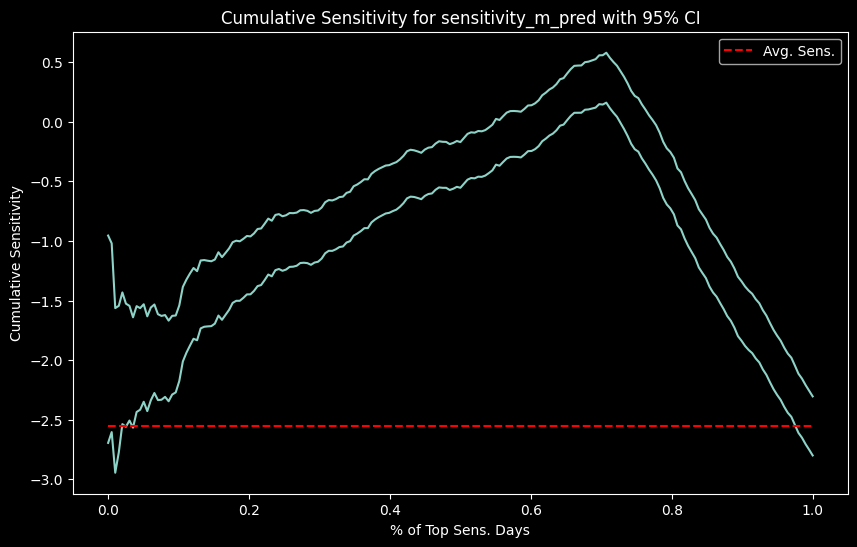

In [52]:
def sensitivity_ci(df, y, t, z=1.96):
    n = df.shape[0]
    t_bar = df[t].mean()
    beta1 = sensitivity(df, y, t)
    beta0 = df[y].mean() - beta1 * t_bar
    e = df[y] - (beta0 + beta1*df[t])
    se = np.sqrt(((1/(n-2))*np.sum(e**2))/np.sum((df[t]-t_bar)**2))
    return np.array([beta1 - z*se, beta1 + z*se])

def cumulative_sensitivity_curve_ci(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    
    # just replacing a call to `sensitivity` by a call to `sensitivity_ci`
    return np.array([sensitivity_ci(ordered_df.head(rows), y, t)  for rows in n_rows])

plt.figure(figsize=(10,6))

cumu_gain_ci = cumulative_sensitivity_curve_ci(prices_rnd_pred, "sensitivity_m_pred", "sales", "price", min_periods=50, steps=200)
x = np.array(range(len(cumu_gain_ci)))
plt.plot(x/x.max(), cumu_gain_ci, color="C0")

plt.hlines(sensitivity(prices_rnd_pred, "sales", "price"), 0, 1, linestyles="--", color="red", label="Avg. Sens.")

plt.xlabel("% of Top Sens. Days")
plt.ylabel("Cumulative Sensitivity")
plt.title("Cumulative Sensitivity for sensitivity_m_pred with 95% CI")
plt.legend();

This is ALL conditioned on having random eval data 